# Auto-Valuation Model (AVM)

In this linear regression model, we will be using the property information, monthly supermarket retail sales, and economic indicators (such as inflation)s, to generate the optimal regression function and predict Net Operating Income. The predicted NOI can then be used to determine the property's cap rate and test alternative values for the features in the model. An example of this would be a testing the shift in cap rates as a result of higher inflation or increased retail sales. Another example would be inputting alternate property features, such as the sale price, square feet, and the year sold, and determining the NOI for a property with these parameters.

In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

/Users/isaiaherb/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/isaiaherb/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


### Linear Regression

In [3]:
df_property = pd.read_csv('/Users/isaiaherb/Documents/Northbow/WholeFoods.csv')

In [4]:
def fetch_census_data(file_path, sheet):
    df = pd.read_excel(file_path,sheet_name=sheet,skiprows=4)
    df.set_index('Unnamed: 1', inplace=True)
    df = df.drop(columns='Unnamed: 0')
    df_filtered = df.iloc[[27,28,29]]
    df_transposed = df_filtered.transpose()
    df = df_transposed.rename_axis('Date',axis='index')
    df = df.rename_axis('Store Type', axis='columns')    
    return df

In [5]:
file_path_main = '/Users/isaiaherb/Documents/Northbow/mrtssales92-present.xlsx'

In [6]:
df_10 = fetch_census_data(file_path=file_path_main,sheet='2010')
df_11 = fetch_census_data(file_path=file_path_main,sheet='2011')
df_12 = fetch_census_data(file_path=file_path_main,sheet='2012')
df_13 = fetch_census_data(file_path=file_path_main,sheet='2013')
df_14 = fetch_census_data(file_path=file_path_main,sheet='2014')
df_15 = fetch_census_data(file_path=file_path_main,sheet='2015')
df_16 = fetch_census_data(file_path=file_path_main,sheet='2016')
df_17 = fetch_census_data(file_path=file_path_main,sheet='2017')
df_18 = fetch_census_data(file_path=file_path_main,sheet='2018')
df_19 = fetch_census_data(file_path=file_path_main,sheet='2019')
df_20 = fetch_census_data(file_path=file_path_main,sheet='2020')
df_21 = fetch_census_data(file_path=file_path_main,sheet='2021')
df_22 = fetch_census_data(file_path=file_path_main,sheet='2022')
df_retail_sales = pd.concat([df_10,df_11,df_12,df_13,df_14,df_15,df_16,df_17,df_18,df_19,df_20,df_21,df_22])

In [7]:
df_property['sale_date'] = pd.to_datetime(df_property['sale_date'], format='%m/%Y')

In [8]:
df_retail_sales.head()

Store Type,Food and beverage stores,Grocery stores,Supermarkets and other grocery (except convenience) stores
Date,,,
Jan. 2010,47072.0,42985.0,41185.0
Feb. 2010,44275.0,40061.0,38400.0
Mar. 2010,48123.0,43434.0,41542.0
Apr. 2010,47050.0,42236.0,40354.0
May 2010,49655.0,44607.0,42658.0


In [9]:
df_retail_sales.reset_index(inplace=True)
df_retail_sales.rename(columns={'index': 'Date'}, inplace=True)

In [10]:
df_retail_sales.head()

Store Type,Date,Food and beverage stores,Grocery stores,Supermarkets and other grocery (except convenience) stores
0,Jan. 2010,47072.0,42985.0,41185.0
1,Feb. 2010,44275.0,40061.0,38400.0
2,Mar. 2010,48123.0,43434.0,41542.0
3,Apr. 2010,47050.0,42236.0,40354.0
4,May 2010,49655.0,44607.0,42658.0


In [11]:
formats = ['%b. %Y', '%b %Y']
for fmt in formats:
    try:
        df_retail_sales['Date'] = pd.to_datetime(df_retail_sales['Date'], format=fmt)
        break  
    except ValueError:
        pass 

In [12]:
df_retail_sales.head()

Store Type,Date,Food and beverage stores,Grocery stores,Supermarkets and other grocery (except convenience) stores
0,Jan. 2010,47072.0,42985.0,41185.0
1,Feb. 2010,44275.0,40061.0,38400.0
2,Mar. 2010,48123.0,43434.0,41542.0
3,Apr. 2010,47050.0,42236.0,40354.0
4,May 2010,49655.0,44607.0,42658.0


In [13]:
df_retail_sales = df_retail_sales[df_retail_sales['Date'] != 'TOTAL']

In [14]:
df_retail_sales['Date'] = pd.to_datetime(df_retail_sales['Date'],format='mixed')

In [15]:
df_retail_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 0 to 167
Data columns (total 4 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Date                                                        156 non-null    datetime64[ns]
 1   Food and beverage stores                                    156 non-null    object        
 2   Grocery stores                                              156 non-null    object        
 3   Supermarkets and other grocery (except convenience) stores  156 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 6.1+ KB


In [16]:
df_property['Month_Year'] = df_property['sale_date'].dt.to_period('M')
df_retail_sales['Month_Year'] = df_retail_sales['Date'].dt.to_period('M')

df_property.drop(columns=['sale_date'], inplace=True)
df_retail_sales.drop(columns=['Date'], inplace=True)

merged_df = pd.merge(df_property, df_retail_sales, on='Month_Year', how='left')

In [17]:
merged_df.head()

,year_sold,property_name,city,state,total_sf,price,price_per_sf,noi,multi_single_tenant,federal_funds_rate,interest_rate,inflation,10_year_treasury,cap_rate,gdp,Month_Year,Food and beverage stores,Grocery stores,Supermarkets and other grocery (except convenience) stores
0,2010,Springbrook Praries Pavillion,Naperville,IL,319401,47163836.0,147.66,3183558.93,1,0.0018,0.0164,0.0469,0.0322,0.0675,69452217000,2010-07,49732.0,44559.0,42598.0
1,2010,Willow Festival,Northbrook,IL,113692,21592225.0,189.92,1403494.63,1,0.0018,0.0164,0.0469,0.0322,0.0650,320358759000,2010-12,53550.0,46658.0,44770.0
2,2011,Whole Foods - Denver,Denver,CO,141818,29935841.0,211.09,2065573.03,1,0.0010,0.0316,0.0445,0.0278,0.0690,52411746000,2011-11,51352.0,46046.0,44156.0
3,2011,Whole Foods - Fairfield,Fairfield,CT,5000,26725168.0,5345.03,1469884.24,1,0.0010,0.0316,0.0445,0.0278,0.0550,82853670000,2011-12,56065.0,48843.0,46916.0
4,2011,Tower Shops,Davie,FL,289303,58462337.0,202.08,3770820.74,1,0.0010,0.0316,0.0445,0.0278,0.0645,81772409000,2011-01,48438.0,44282.0,42501.0


In [46]:
merged_df = merged_df[merged_df['noi'] <= 5000000]

In [47]:
merged_df['Food and beverage stores'] = pd.to_numeric(merged_df['Food and beverage stores'], errors='coerce')
merged_df['Grocery stores'] = pd.to_numeric(merged_df['Grocery stores'], errors='coerce')
merged_df['Supermarkets and other grocery (except convenience) stores'] = pd.to_numeric(merged_df['Supermarkets and other grocery (except convenience) stores'], errors='coerce')


In [48]:
X = merged_df.drop(['noi', 'cap_rate', 'inflation', 'multi_single_tenant','Supermarkets and other grocery (except convenience) stores', 'Month_Year', 'price_per_sf', 'property_name', 'city', 'state','10_year_treasury', 'gdp', 'federal_funds_rate', 'interest_rate', 'Food and beverage stores', 'Grocery stores'], axis=1)
y = merged_df['noi']

In [49]:
X = sm.add_constant(X)

In [38]:
model = sm.OLS(y, X).fit()

In [39]:
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                    noi   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     712.3
Date:                Thu, 27 Jun 2024   Prob (F-statistic):           7.99e-76
Time:                        20:50:25   Log-Likelihood:                -1810.9
No. Observations:                 123   AIC:                             3630.
Df Residuals:                     119   BIC:                             3641.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.229e+07   2.86e+07      0.778      0.4

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df_property[['year_sold', 'total_sf', 'price', 'multi_single_tenant']]
X = add_constant(X)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

              Variable            VIF
0                const  279575.961865
1            year_sold       1.035789
2             total_sf       1.523285
3                price       1.544954
4  multi_single_tenant       1.177710


**Multicollinearity Check:** All values are less than 10, indicating multicollinearity is not an issue.

In [43]:
predictions = model.predict(X)

ValueError: shapes (123,3) and (4,) not aligned: 3 (dim 1) != 4 (dim 0)

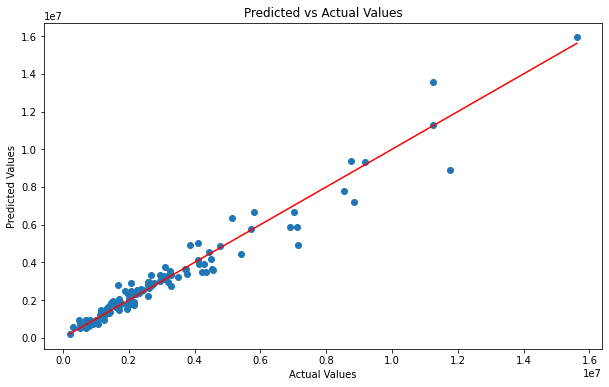

In [44]:
plt.figure(figsize=(10,6))
plt.scatter(y, predictions)
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red')
plt.show()

In [45]:
mse = mean_squared_error(y, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 329698638777.2561


In [26]:
acceptable_margin = 0.001
absolute_errors = abs(y - predictions)
unacceptable_predictions = sum(absolute_errors > acceptable_margin)
error_rate = unacceptable_predictions / len(predictions)

print("Error Rate:", error_rate)

Error Rate: 1.0


In [27]:
pd.DataFrame(predictions)
predictions

0      2.952011e+06
1      1.683861e+06
2      2.016992e+06
3      1.836528e+06
4      3.396542e+06
           ...     
118    2.039304e+06
119    1.878202e+06
120    1.316686e+06
121    4.942187e+06
122    2.941657e+06
Length: 123, dtype: float64

In [28]:
wholefoodsdf['predicted_cap_rate'] = predictions

NameError: name 'wholefoodsdf' is not defined

In [ ]:
wholefoodsdf.to_excel('cap_rate_prediction_model.xlsx', sheet_name='CapRatePredictions', index=False, engine='openpyxl')

In [ ]:
import openpyxl

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(12, 6))

sns.kdeplot(wholefoodsdf['cap_rate'], label='Actual', shade=True)

sns.kdeplot(wholefoodsdf['predicted_cap_rate'], label='Predicted', shade=True)

plt.title('Distribution of Actual and Predicted Values')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()

plt.show()

In [ ]:
wholefoodsdf['error'] = abs(wholefoodsdf['predicted_cap_rate'] - wholefoodsdf['cap_rate'])

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(wholefoodsdf['predicted_cap_rate'], wholefoodsdf['error'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [ ]:
def learning_curve_statsmodels(X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes = np.array(train_sizes)
    n_train_sizes = len(train_sizes)
    train_scores = np.zeros(n_train_sizes)
    test_scores = np.zeros(n_train_sizes)
    
    kf = KFold(n_splits=cv)
    
    for i, train_size in enumerate(train_sizes):
        train_errors = []
        test_errors = []
        
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            X_train_sample = X_train.iloc[:int(len(X_train) * train_size)]
            y_train_sample = y_train.iloc[:int(len(y_train) * train_size)]
            
            X_train_sample = sm.add_constant(X_train_sample)
            X_test = sm.add_constant(X_test)
            
            model = sm.OLS(y_train_sample, X_train_sample).fit()
            y_train_pred = model.predict(X_train_sample)
            y_test_pred = model.predict(X_test)
            
            train_errors.append(mean_absolute_error(y_train_sample, y_train_pred))
            test_errors.append(mean_absolute_error(y_test, y_test_pred))
        
        train_scores[i] = np.mean(train_errors)
        test_scores[i] = np.mean(test_errors)
    
    return train_sizes, train_scores, test_scores

In [ ]:
train_sizes, train_scores, test_scores = learning_curve_statsmodels(X, y, cv=5)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes * len(X), train_scores, 'o-', color="r", label="Training score")
plt.plot(train_sizes * len(X), test_scores, 'o-', color="g", label="Cross-validation score")

plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(loc="best")
plt.show()
